# Прогнозирование температуры звезды

# Содержание

- [Введенние](#intro)
- [Загрузка данных](#data)
- [Предобработка и анализ данных](#pre_analysis)
  - [Предобработка](#preprocessing)
  - [Анализ](#analysis)
  - [Добавление данных](#new_data)
  - [Выводы по предобработке и анализу](#pre_analysis_conclusion)
- [Построение базовой нейронной сети](#baseline_nn)
  - [Выводы по базовой сети](#nn_conclusion)
- [Улучшение нейронной сети](#imp_nn)
- [Выводы](#conclusion)

<a id='intro'></a>
## Введение

Нам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд. Используя их надо создать нейросеть которая сможет определять температуру на поверхности звёзд. Изучим данные, при необходимости сделаем предобработку. Подготовим данные для модели. В качестве метрики качества используем RMSE.

<a id='data'></a>
## Загрузка данных

**Импортируем необходимые библиотеки**

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

**Читаем файл с предоставленными данными**

In [2]:
data = pd.read_csv('6_class.csv')

**Основная информация о датафрейме**

Посмотрим на данные.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [4]:
data.head(10)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
5,5,2840,0.000650,0.1100,16.98,0,Red
6,6,2637,0.000730,0.1270,17.22,0,Red
7,7,2600,0.000400,0.0960,17.40,0,Red
8,8,2650,0.000690,0.1100,17.45,0,Red
9,9,2700,0.000180,0.1300,16.05,0,Red


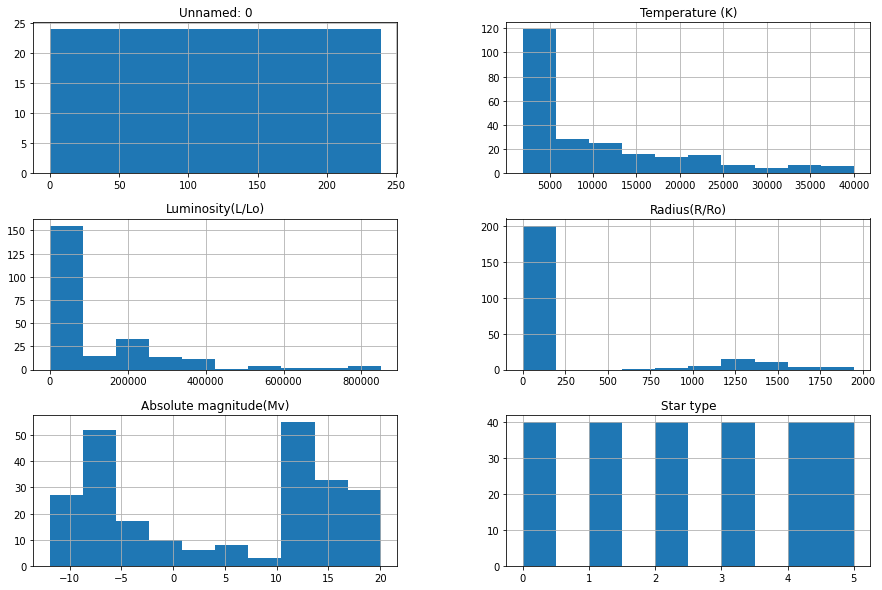

In [5]:
data.hist(figsize=(15, 10));

В датафрейме 240 строк (звёзд). Присутствуют 7 колонок, одна из них называется `Unnamed` и содержит неизвестные на первый вгляд значения, на этапе предобработки подробнее её рассмотрим.

<a id='pre_analysis'></a>
## Предобработка и анализ данных

<a id='preprocessing'></a>
### Предобработка

Приступим к предобработке.

Изучим колонку `Star color` которая содержить названия цветов звёзд. Для начала проверим есть ли дубликаты.

In [6]:
display(data['Star color'].nunique())
display(data['Star color'].unique())

19

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Нашли 19 разные наименований цветов. Видим что в названиях притсвуют пробелы и различные варианты написания одного и того же цвета. Для начала приведёт все значения к одному регистрку и удалим пробелы.

In [7]:
data['Star color'] = data['Star color'].str.lower()
data['Star color'] = data['Star color'].str.rstrip()

In [8]:
display(data['Star color'].nunique())
display(data['Star color'].unique())

13

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

Количество сократилось до 13. Ещё остались такие дубликаты как blue white и blue-white. А так же спектральная классификация включает в себя только 7 классов. Типы O, B, A, F, G, K, M разделенные по температуре. В разных источниках названия могут немного отличатся, но границы температур и их типы остаются теми же. Например pale yellow orange из датасета относится к классу K с температурой в диапазоне 3,700 - 5,200 кельвин, но более часто встречается название этого класса как просто orange. Примем классификацию Red, Orange, Yellow, Yellow White, White, Blue White, Blue. Так же сверимся с температурами, возможно там будут аномалии.

Цвета должны находится в следующих диапазонах:

- red: < 3,700K
- orange: 3,700 - 5,200K
- yellow: 5,200 - 6,000K
- yellow white:  6,000 - 7,500K
- white: 7,500 - 10,000K
- blue white: 10,000 - 30,000\
- blue: > 30,000K

In [9]:
data.groupby('Star color')['Temperature (K)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star color,,,,,,,,
blue,56.0,21918.339286,9453.979609,5752.0,14797.75,19921.5,27489.50,40000.0
blue white,14.0,13478.214286,4187.508497,8570.0,11210.00,12948.0,14415.00,25000.0
blue-white,27.0,18309.740741,7011.517292,8945.0,12099.00,17140.0,24317.50,30000.0
orange,2.0,4018.000000,380.423448,3749.0,3883.50,4018.0,4152.50,4287.0
orange-red,1.0,5112.000000,NaN,5112.0,5112.00,5112.0,5112.00,5112.0
pale yellow orange,1.0,7230.000000,NaN,7230.0,7230.00,7230.0,7230.00,7230.0
red,112.0,3291.785714,490.780761,1939.0,2987.50,3324.0,3550.75,6850.0
white,10.0,9720.300000,2563.623176,7220.0,7930.00,8879.5,10239.25,14732.0
white-yellow,1.0,7100.000000,NaN,7100.0,7100.00,7100.0,7100.00,7100.0


В большинстве случаев названия не соответсвующие классификации хорошо попадают по температуре в нужные категории. Сделаем замену названий.

In [10]:
data['Star color'] = data['Star color'].replace('blue-white', 'blue white')
data['Star color'] = data['Star color'].replace('orange-red', 'orange')
data['Star color'] = data['Star color'].replace('pale yellow orange', 'yellow white')
data['Star color'] = data['Star color'].replace('white-yellow', 'yellow white')
data['Star color'] = data['Star color'].replace('whitish', 'white')
data['Star color'] = data['Star color'].replace('yellow-white', 'yellow white')
data['Star color'] = data['Star color'].replace('yellowish', 'orange')
data['Star color'] = data['Star color'].replace('yellowish white', 'white')

In [11]:
data.groupby('Star color')['Temperature (K)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star color,,,,,,,,
blue,56.0,21918.339286,9453.979609,5752.0,14797.75,19921.5,27489.50,40000.0
blue white,41.0,16659.951220,6560.050964,8570.0,11900.00,14100.0,22012.00,30000.0
orange,6.0,4455.166667,525.710725,3749.0,4129.50,4406.5,4866.50,5112.0
red,112.0,3291.785714,490.780761,1939.0,2987.50,3324.0,3550.75,6850.0
white,15.0,9829.000000,2402.559409,7220.0,7896.00,8930.0,11182.00,14732.0
yellow white,10.0,6606.000000,971.456753,5300.0,5834.00,6568.5,7197.50,8250.0


Сделали замену, теперь надо подкорректировать аномалии внутри категорий, например среди красных звёзд мы видим что максимум 6850K что значительно больше чем в этой и даже в двух следующих категориях должно быть.

In [12]:
data.loc[(data['Temperature (K)'] > 30000), 'Star color'] = 'blue'

data.loc[(data['Temperature (K)'] < 30000) &
         (data['Temperature (K)'] > 10000), 'Star color'] = 'blue white'

data.loc[(data['Temperature (K)'] < 10000) &
         (data['Temperature (K)'] > 7500), 'Star color'] = 'white'

data.loc[(data['Temperature (K)'] < 7500) &
         (data['Temperature (K)'] > 6000), 'Star color'] = 'yellow white'

data.loc[(data['Temperature (K)'] < 6000) &
         (data['Temperature (K)'] > 5200), 'Star color'] = 'yellow'

data.loc[(data['Temperature (K)'] < 5200) &
         (data['Temperature (K)'] > 3700), 'Star color'] = 'orange'

data.loc[(data['Temperature (K)'] < 3700), 'Star color'] = 'red'

In [13]:
data.groupby('Star color')['Temperature (K)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star color,,,,,,,,
blue,14.0,35600.928571,2999.651453,30839.0,33330.25,35149.0,38146.00,40000.0
blue white,76.0,18036.907895,5445.692850,10012.0,13014.75,17170.0,23023.00,30000.0
orange,12.0,4140.666667,487.846349,3749.0,3773.00,3924.5,4346.75,5112.0
red,105.0,3227.361905,337.936104,1939.0,2968.00,3295.0,3523.00,3692.0
white,21.0,8781.809524,695.592813,7700.0,8250.00,8927.0,9320.00,9892.0
yellow,5.0,5675.000000,243.948765,5300.0,5587.00,5752.0,5800.00,5936.0
yellow white,7.0,6974.142857,329.669748,6380.0,6803.50,7100.0,7225.00,7282.0


Исправили названия цветов у звезд в соответствии с их температурой.

Посмотрим какие значения находятся в `Star type`.

In [14]:
data['Star type'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

Значения в `Star type` корректные.

Из того что было видно по гистограмме и по первым 10 строкам есть предположение что в `Unnamed: 0` находятся своего рода индексы, на уникальные значения в данной колонке.

In [15]:
data['Unnamed: 0'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Первоначальное предположение подтвердилось, данная колонка для обучения модели нам не понадобится. Удалим её.

In [16]:
data = data.drop(['Unnamed: 0'], axis=1).reset_index(drop=True)

`Unnamed: 0` удалили, оставшиеся колонки содержащие температуру, радиус и абсолютную зведную величину по гистограммам выглядят логично. Приступим к анализу имеющихся данных.

<a id='analysis'></a>
### Анализ данных

In [17]:
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Рассмотрим `Star type`, изучим есть ли кореляция с другими признаками.

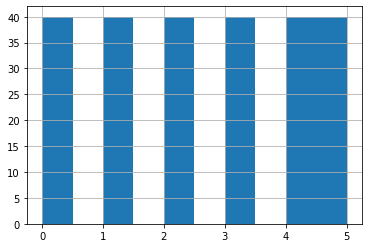

In [18]:
data['Star type'].hist();

В предоставленных данных есть 5 типов звезд и на каждый тип приходится ровно по 40 звезд.

In [19]:
data.groupby('Star type')['Absolute magnitude(Mv)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star type,,,,,,,,
0,40.0,17.563500,1.213111,16.05,16.7000,17.145,18.35250,20.060
1,40.0,12.539975,1.422816,10.12,11.3675,12.605,13.56425,14.940
2,40.0,12.582500,1.278386,10.18,11.5950,12.340,13.83000,14.870
3,40.0,-0.367425,3.613592,-4.70,-3.7025,-1.180,2.42500,6.506
4,40.0,-6.369925,0.560051,-7.45,-6.8075,-6.235,-5.96125,-5.240
5,40.0,-9.654250,1.453605,-11.92,-10.8750,-9.915,-8.14750,-7.580


In [20]:
def scatter_plot(x, y):
    data.plot(x=x,
          y=y,
          kind='scatter',
          grid=True,
          alpha=0.3,
          figsize=(10, 10)
         );

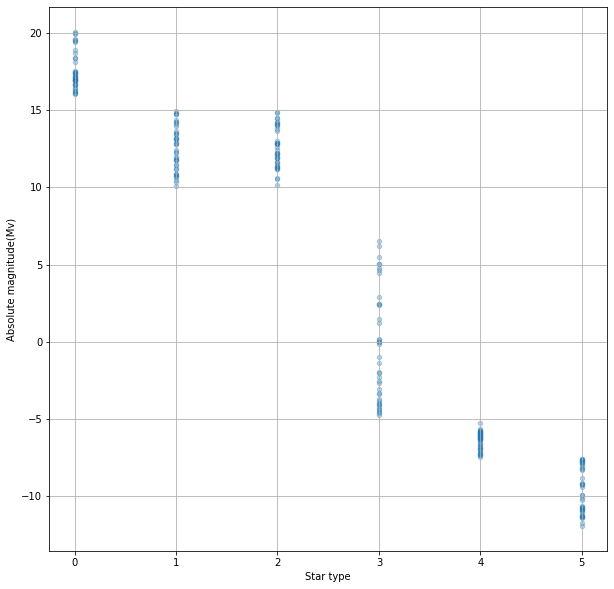

In [21]:
scatter_plot('Star type', 'Absolute magnitude(Mv)')

In [22]:
print(data['Star type'].corr(data['Absolute magnitude(Mv)']))

-0.9552755802305672


Присутствует явная корреляция между типом звезды и абсолютной звездной величины. Чем у типа номер больше там абсолютная звездная величина меньше.

In [23]:
data.groupby('Star type')['Radius(R/Ro)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star type,,,,,,,,
0,40.0,0.110015,0.025783,0.0570,0.093150,0.1060,0.120250,0.190
1,40.0,0.348145,0.154453,0.0980,0.240000,0.3380,0.409750,0.730
2,40.0,0.010728,0.001725,0.0084,0.009305,0.0102,0.012025,0.015
3,40.0,4.430300,2.801390,0.7950,1.287500,5.7125,6.367500,10.600
4,40.0,51.150000,27.656826,12.0000,25.750000,43.5000,80.250000,98.000
5,40.0,1366.897500,255.561357,708.9000,1193.000000,1352.5000,1525.000000,1948.500


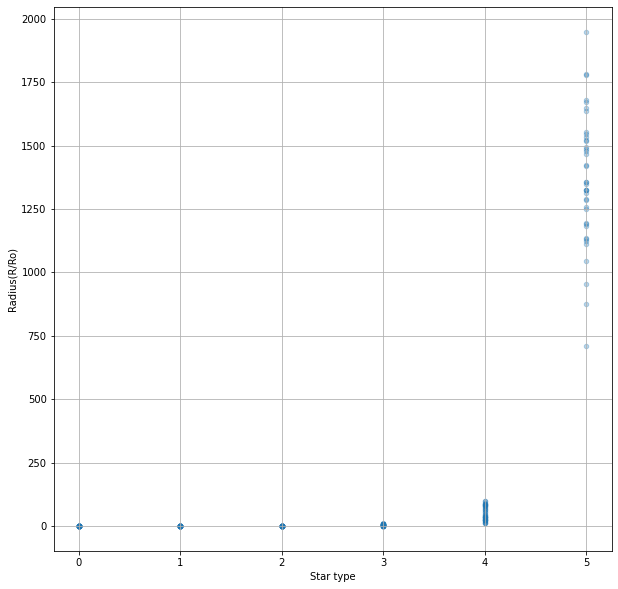

In [24]:
scatter_plot('Star type', 'Radius(R/Ro)')

In [25]:
print(data['Star type'].corr(data['Radius(R/Ro)']))

0.6609752654498471


Присутствует корреляция между типом зведны и радиусом. У типов с большим числом радиус так же больше.

In [26]:
data.groupby('Star type')['Luminosity(L/Lo)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star type,,,,,,,,
0,40.0,0.000693,0.000888,0.000138,0.000315,0.00052,0.000737,0.0056
1,40.0,0.005406,0.007330,0.000190,0.001315,0.00315,0.006675,0.0390
2,40.0,0.002434,0.008912,0.000080,0.000287,0.00076,0.001227,0.0560
3,40.0,32067.386275,69351.195858,0.085000,6.297500,738.50000,12962.500000,204000.0000
4,40.0,301816.250000,175756.378119,112000.000000,197250.000000,242145.00000,344160.000000,813000.0000
5,40.0,309246.525000,199343.999427,74000.000000,173000.000000,266500.00000,365957.500000,849420.0000


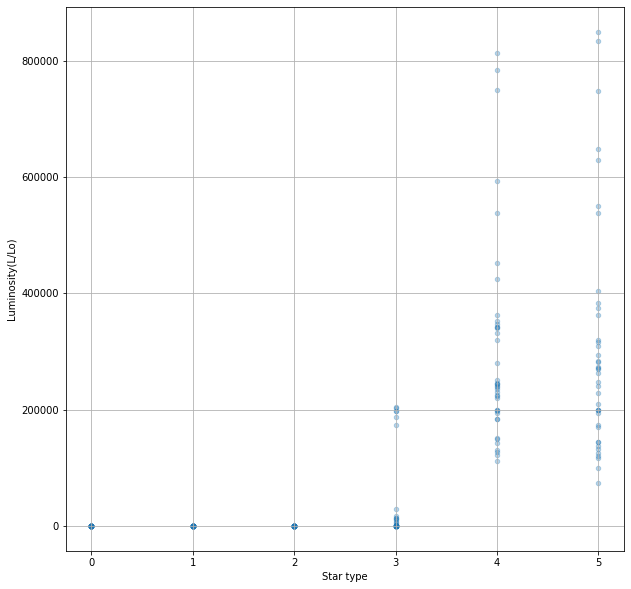

In [27]:
scatter_plot('Star type', 'Luminosity(L/Lo)')

In [28]:
print(data['Star type'].corr(data['Luminosity(L/Lo)']))

0.6768449517263782


Присутствует корреляция между типом зведны и светимостью. У типов с большим числом светимость так же больше.

In [29]:
data.groupby('Star type')['Temperature (K)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star type,,,,,,,,
0,40.0,2997.950,332.276295,1939.0,2812.75,2935.0,3242.50,3531.0
1,40.0,3283.825,269.637258,2621.0,3132.75,3314.0,3527.50,3692.0
2,40.0,13931.450,4957.655189,7100.0,9488.75,13380.0,17380.00,25000.0
3,40.0,16018.000,10661.234972,4077.0,7479.25,12560.5,23030.00,39000.0
4,40.0,15347.850,10086.784628,3008.0,6899.50,12821.0,23181.25,40000.0
5,40.0,11405.700,11816.991886,3399.0,3603.75,3766.0,18976.00,38940.0


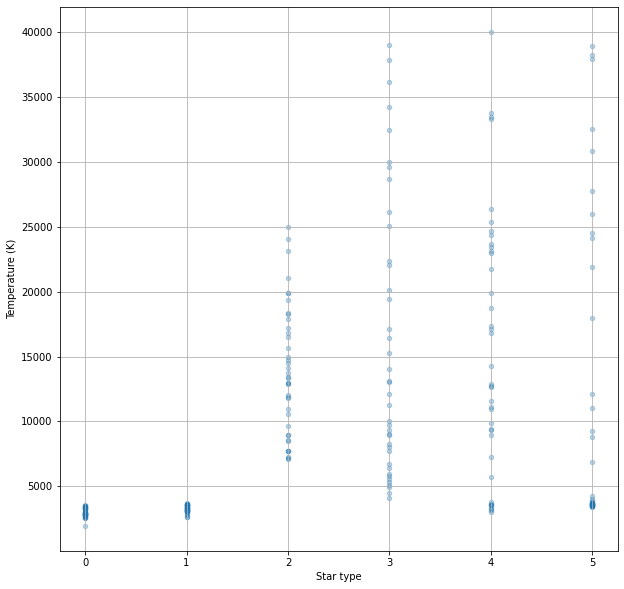

In [30]:
scatter_plot('Star type', 'Temperature (K)')

In [31]:
print(data['Star type'].corr(data['Temperature (K)']))

0.41112879277927034


Явной корреляции между типом звезды и её температурой не наблюдается. Видим что при большом числе типа звезды, стандартное отклонение увеличивается, особенно сильное увеличение происходит между типами 2 и 3.

In [32]:
data.groupby('Star type')['Star color'].describe()

,count,unique,top,freq
Star type,,,,
0,40,1,red,40
1,40,1,red,40
2,40,3,blue white,29
3,40,6,blue white,18
4,40,7,blue white,21
5,40,6,red,17


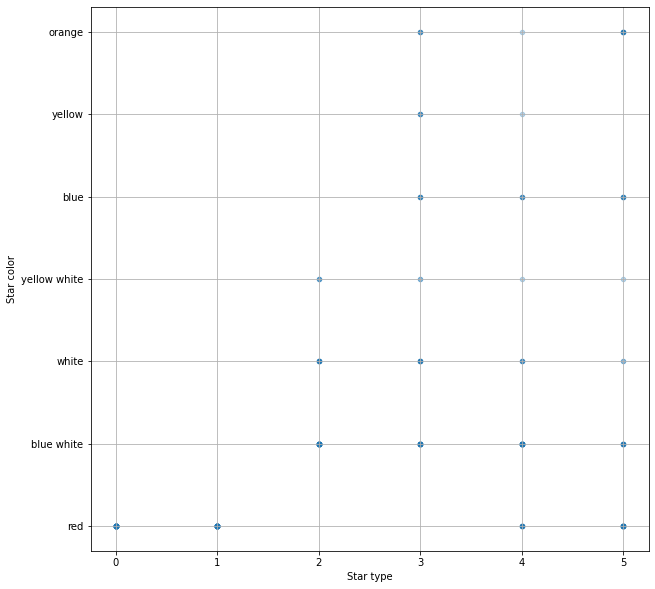

In [33]:
scatter_plot('Star type', 'Star color')

У звезд с типами 0 и 1 цвет попадает только в одну категорию red. У остальных типов корреляция не наблюдается.

Посмотрели на колонку `Star type`. Выяснили что увеличением номера типа звезды растут так же светимость и радиус, а абсолютная звездная величина падает. Явных связей с температурой и цветом не наблюдается.

**Рассмотрим светимость.**

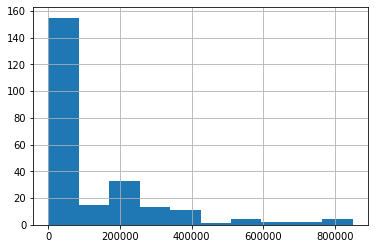

In [34]:
data['Luminosity(L/Lo)'].hist();

In [35]:
data['Luminosity(L/Lo)'].describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64

Большая часть значений имеет светимость меньше 1 L/Lo.

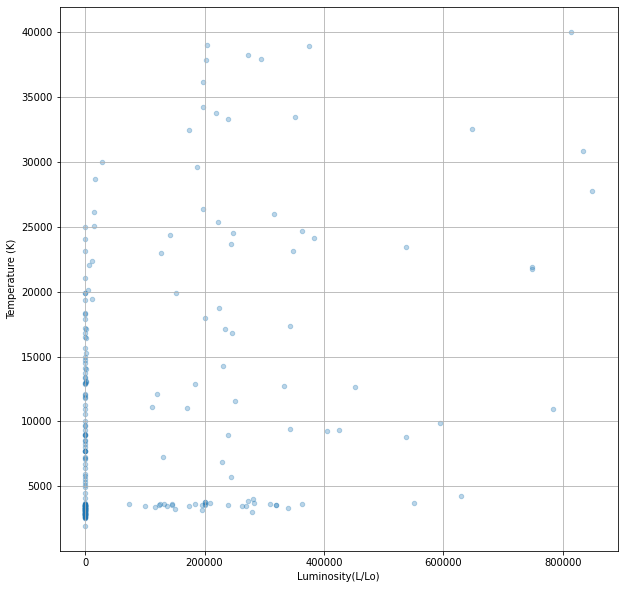

In [36]:
scatter_plot('Luminosity(L/Lo)', 'Temperature (K)')

In [37]:
print(data['Luminosity(L/Lo)'].corr(data['Temperature (K)']))

0.39340407550976086


Корреляция между светимостью и температурой отсутствует.

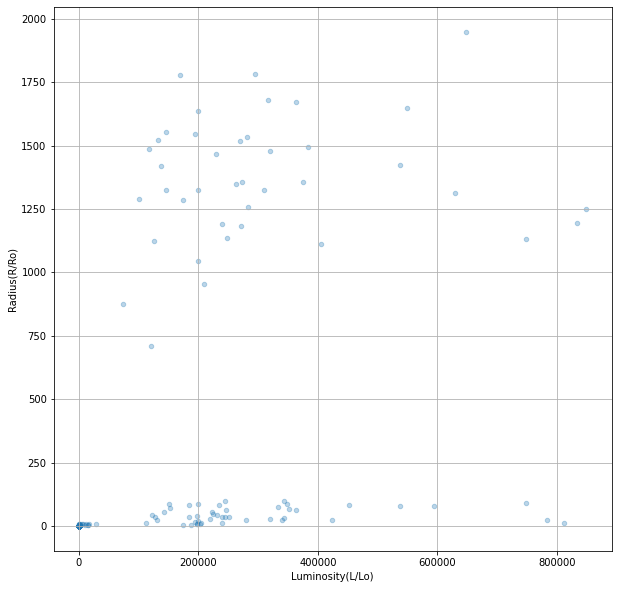

In [38]:
scatter_plot('Luminosity(L/Lo)', 'Radius(R/Ro)')

In [39]:
print(data['Luminosity(L/Lo)'].corr(data['Radius(R/Ro)']))

0.5265157243480014


Корреляция между светимостью и радиусом отсутствует.

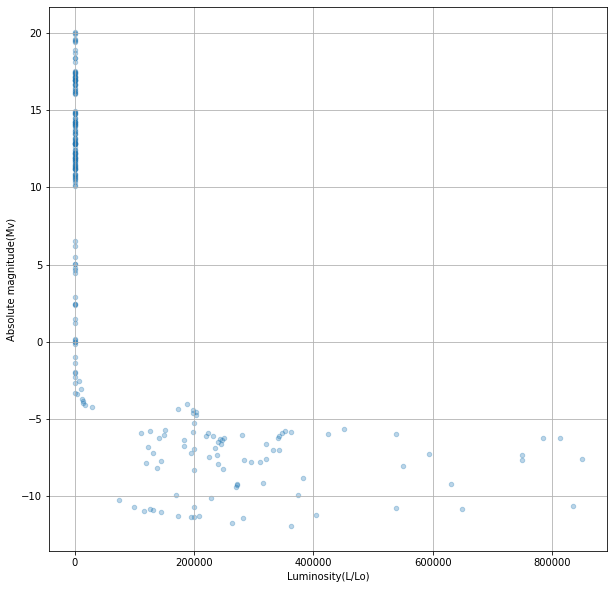

In [40]:
scatter_plot('Luminosity(L/Lo)', 'Absolute magnitude(Mv)')

In [41]:
print(data['Luminosity(L/Lo)'].corr(data['Absolute magnitude(Mv)']))

-0.6926192333999417


Присутствует корреляция между светимостью и абсолютной звездной величиной. При большей светомости абсолютная зведная величина уменьшается, а так же увеличивается разброс значений.

In [42]:
data.groupby('Star color')['Luminosity(L/Lo)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star color,,,,,,,,
blue,14.0,359066.785714,231273.188015,173800.000000,203175.000000,256415.0000,369122.500,834042.0
blue white,76.0,129213.935440,204237.257033,0.000085,0.001243,2999.0000,223445.000,849420.0
orange,12.0,218833.435417,209332.517242,0.085000,0.561750,204500.0000,282250.000,630000.0
red,105.0,48609.526133,96057.122767,0.000138,0.000600,0.0018,0.022,363000.0
white,21.0,121095.470159,206469.374473,0.000110,0.000500,9.2500,239000.000,593900.0
yellow,5.0,49000.715200,109566.931089,0.590000,0.810000,0.8190,1.357,245000.0
yellow white,7.0,51428.968649,92274.435147,0.000080,0.000230,1.3500,65500.715,229000.0


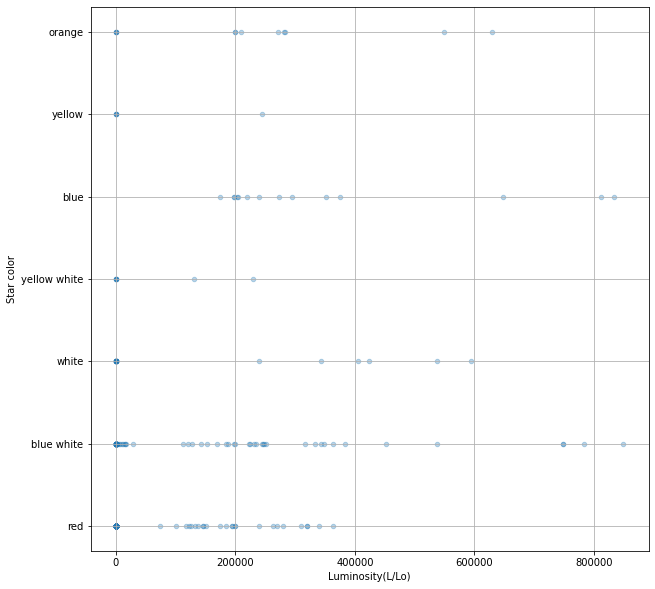

In [43]:
scatter_plot('Luminosity(L/Lo)', 'Star color')

Корреляция между цветом звезды и светимостью отсутствует. У звезд из категории blue минимальная светимость значительно превышает минимумы остальных.

Посмотрели на колонку `Luminosity(L/Lo)`. Помимо корреляции с типом звезды, так же обнаружили корреляцию с абсолютной звездной величиной, с остальными признаками нет корреляции.

**Рассмотрим радиус.**

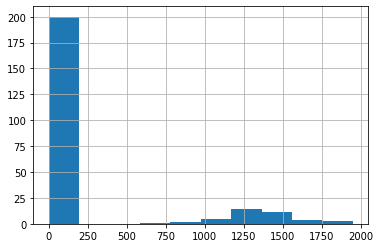

In [44]:
data['Radius(R/Ro)'].hist();

In [45]:
data['Radius(R/Ro)'].describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64

Большая часть значений имеет радиус меньше 1 R/Ro.

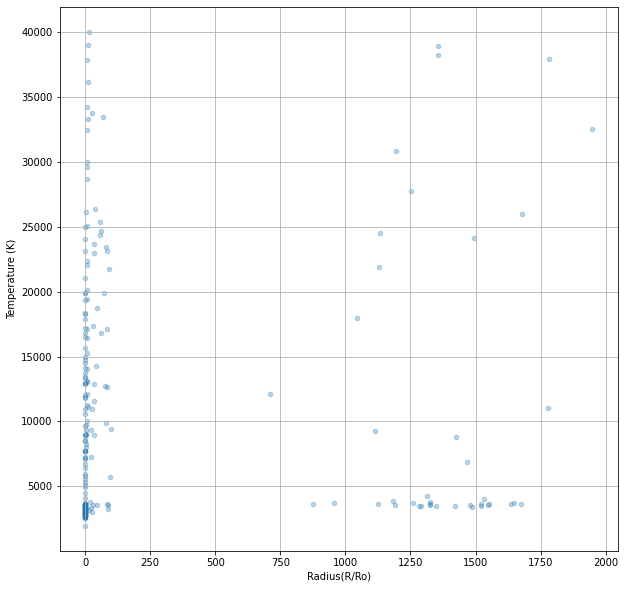

In [46]:
scatter_plot('Radius(R/Ro)', 'Temperature (K)')

Связь между радиусом и температурой отсутствует.

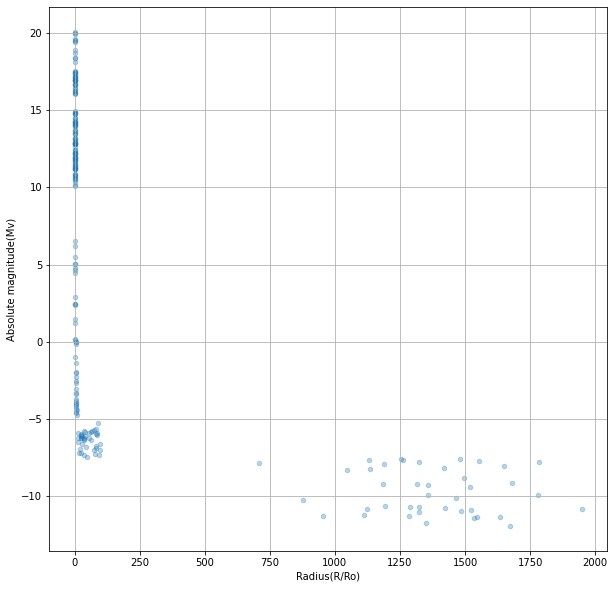

In [47]:
scatter_plot('Radius(R/Ro)', 'Absolute magnitude(Mv)')

In [48]:
print(data['Radius(R/Ro)'].corr(data['Absolute magnitude(Mv)']))

-0.6087282328465596


Присутствет связь между радиусом и абсолютной зведной величиной. У звезд с большим радиусом абсолютная звездная величина всегда малая.

In [49]:
data.groupby('Star color')['Radius(R/Ro)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star color,,,,,,,,
blue,14.0,556.913357,771.739425,6.23700,10.300000,20.000,1315.500,1948.5
blue white,76.0,151.118109,404.654440,0.00840,0.011275,6.120,48.750,1779.0
orange,12.0,770.138833,696.313249,0.79500,1.066500,1069.000,1317.250,1648.0
red,105.0,228.698347,518.262345,0.05700,0.116000,0.258,0.675,1673.0
white,21.0,132.717610,381.406517,0.00878,0.010900,1.910,24.000,1423.0
yellow,5.0,20.181200,42.943094,0.90000,0.910000,0.990,1.106,97.0
yellow white,7.0,213.305143,552.897463,0.01100,0.012500,0.980,12.560,1467.0


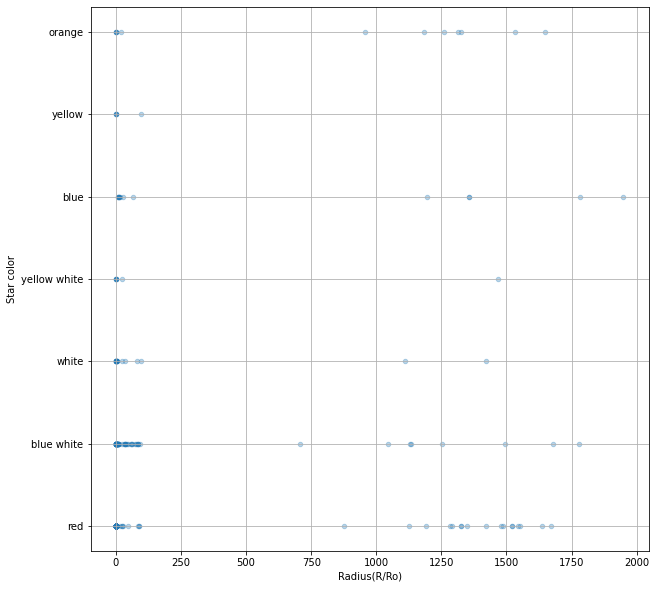

In [50]:
scatter_plot('Radius(R/Ro)', 'Star color')

Связи между радиусом и цветом звезды нет.

Посмотрели на колонку `Radius(R/Ro)`. Помимо корреляции с типом звезды, так же обнаружили корреляцию с абсолютной звездной величиной, с остальными признаками нет корреляции.

**Рассмотрим абсолютную звездную величину.**

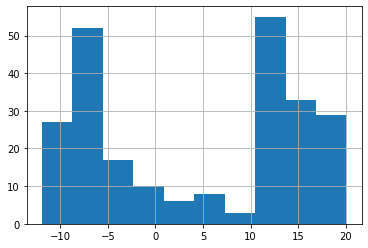

In [51]:
data['Absolute magnitude(Mv)'].hist();

In [52]:
data['Absolute magnitude(Mv)'].describe()

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64

Распределение абсолютной звездной величины бимодальное с пиками в районе -6 Mv и 13 Mv.

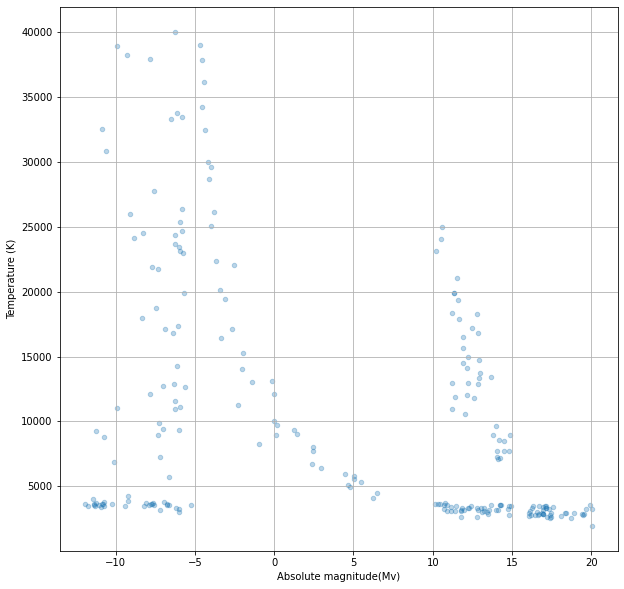

In [53]:
scatter_plot('Absolute magnitude(Mv)', 'Temperature (K)')

Явной зависимости между температурой и абсолютной величиной нет.

In [54]:
data.groupby('Star color')['Absolute magnitude(Mv)'].describe()

,count,mean,std,min,25%,50%,75%,max
Star color,,,,,,,,
blue,14.0,-6.835714,2.418021,-10.84,-8.9175,-6.165,-4.6025,-4.360
blue white,76.0,1.332211,8.618058,-9.90,-6.0975,-2.860,11.5450,13.670
orange,12.0,-4.345500,7.447699,-11.39,-9.5750,-7.840,4.7050,6.506
red,105.0,9.357895,10.584353,-11.92,10.3400,13.450,16.9300,20.060
white,21.0,3.425905,9.607390,-11.23,-5.9900,1.450,14.0200,14.870
yellow,5.0,2.680000,5.217279,-6.63,4.4600,5.030,5.0500,5.490
yellow white,7.0,4.350000,10.285396,-10.07,-2.4050,2.930,14.0850,14.230


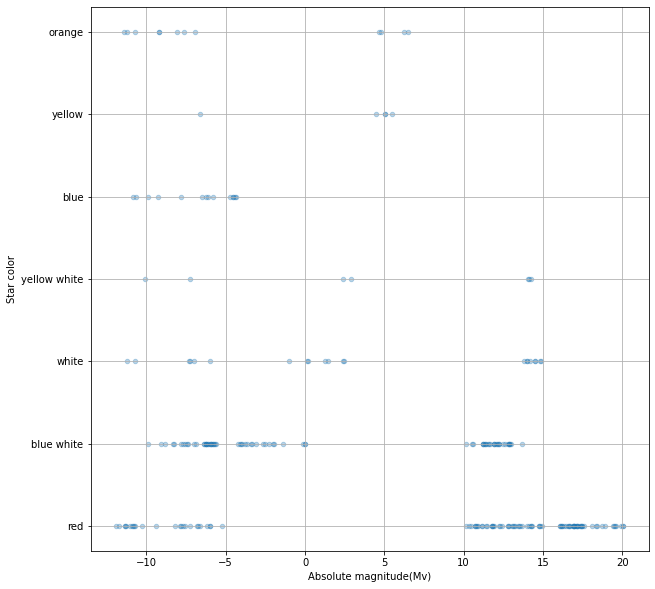

In [55]:
scatter_plot('Absolute magnitude(Mv)', 'Star color')

В целом у красных звезд абсолютная величина больше чем у других категорий, в то время как у синих наоборот.

<a id='new_data'></a>
### Добавление данных

Используя имеющиеся данные мы можем расширить наш датасет добавив в него дополнительные колонки. Для начала запишем нужные нам константы.

In [56]:
stefan_boltzmann_constant = 5.670374e-8  # Постоянная Стефана — Больцмана W/(m^2*K^4)
luminosity_constant = 3.828e26  # Светимость солнца (Ватты)
solar_radius_constant = 6.9551e8  # Радиус солнца (метры)
mass_of_the_sun =  1.989e30 #  Масса солнца (kg)
G = 6.67430e-11 # Гравитационная постоянная

Преобразуем светимость и радиус в другие единицы измерения (Ватты и метры), они нам понадобятся для расчётов. Перемножив L/Lo на светимость солнца и R/Ro на радиус солнца мы получим нужные величины. Напишем функцию которая добавит в датасет светимость и радиус в нужных нам единицах измерения.

In [57]:
data['Luminosity (Watts)'] = data['Luminosity(L/Lo)'] * luminosity_constant
data['Radius (meters)'] = data['Radius(R/Ro)'] * solar_radius_constant

In [58]:
display(data)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Luminosity (Watts),Radius (meters)
0,3068,0.002400,0.1700,16.12,0,red,9.187200e+23,1.182367e+08
1,3042,0.000500,0.1542,16.60,0,red,1.914000e+23,1.072476e+08
2,2600,0.000300,0.1020,18.70,0,red,1.148400e+23,7.094202e+07
3,2800,0.000200,0.1600,16.65,0,red,7.656000e+22,1.112816e+08
4,1939,0.000138,0.1030,20.06,0,red,5.282640e+22,7.163753e+07
...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,blue,1.434849e+32,9.431116e+11
236,30839,834042.000000,1194.0000,-10.63,5,blue,3.192713e+32,8.304389e+11
237,8829,537493.000000,1423.0000,-10.73,5,white,2.057523e+32,9.897107e+11
238,9235,404940.000000,1112.0000,-11.23,5,white,1.550110e+32,7.734071e+11


Теперь мы можем приступить к добавлению данных, начнём с массы. Будем использовать "Зависимость масса — светимость" правило для расчёта примерной массы звезды. $L/L☉ = (M/M☉)^a$. $M/M☉$ это масса звезды поделённая на массу солнца. $a$ - значение которое может менятся для звёзд с различной массой, но для звезд главной последовательности (к ним принадлежат 90% звезд) значение обычно принимается за 3.5. Из этого следует: 
$$M/M☉ = (L/L☉)^{(1/3.5)}$$
$$M = M☉ * (L/L☉)^{(1/3.5)}$$

У нас есть все необходимые данные для использования данной формулы.

In [59]:
data['Mass (kg)'] = mass_of_the_sun * (data['Luminosity(L/Lo)'])**(1/3.5)

In [60]:
display(data)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Luminosity (Watts),Radius (meters),Mass (kg)
0,3068,0.002400,0.1700,16.12,0,red,9.187200e+23,1.182367e+08,3.549145e+29
1,3042,0.000500,0.1542,16.60,0,red,1.914000e+23,1.072476e+08,2.267166e+29
2,2600,0.000300,0.1020,18.70,0,red,1.148400e+23,7.094202e+07,1.959287e+29
3,2800,0.000200,0.1600,16.65,0,red,7.656000e+22,1.112816e+08,1.744963e+29
4,1939,0.000138,0.1030,20.06,0,red,5.282640e+22,7.163753e+07,1.569434e+29
...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,blue,1.434849e+32,9.431116e+11,7.783212e+31
236,30839,834042.000000,1194.0000,-10.63,5,blue,3.192713e+32,8.304389e+11,9.781439e+31
237,8829,537493.000000,1423.0000,-10.73,5,white,2.057523e+32,9.897107e+11,8.627484e+31
238,9235,404940.000000,1112.0000,-11.23,5,white,1.550110e+32,7.734071e+11,7.956946e+31


Теперь когда мы знаем массу мы можем посчитать поверхностную гравитацию.
$$g = \frac{GM}{R^2}$$

In [61]:
data['Surface Gravity (m/s^2)'] = (G * data['Mass (kg)']) / (data['Radius (meters)'] ** 2)

In [62]:
display(data)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Luminosity (Watts),Radius (meters),Mass (kg),Surface Gravity (m/s^2)
0,3068,0.002400,0.1700,16.12,0,red,9.187200e+23,1.182367e+08,3.549145e+29,1694.434685
1,3042,0.000500,0.1542,16.60,0,red,1.914000e+23,1.072476e+08,2.267166e+29,1315.568829
2,2600,0.000300,0.1020,18.70,0,red,1.148400e+23,7.094202e+07,1.959287e+29,2598.343844
3,2800,0.000200,0.1600,16.65,0,red,7.656000e+22,1.112816e+08,1.744963e+29,940.470574
4,1939,0.000138,0.1030,20.06,0,red,5.282640e+22,7.163753e+07,1.569434e+29,2041.115640
...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,blue,1.434849e+32,9.431116e+11,7.783212e+31,0.005840
236,30839,834042.000000,1194.0000,-10.63,5,blue,3.192713e+32,8.304389e+11,9.781439e+31,0.009467
237,8829,537493.000000,1423.0000,-10.73,5,white,2.057523e+32,9.897107e+11,8.627484e+31,0.005879
238,9235,404940.000000,1112.0000,-11.23,5,white,1.550110e+32,7.734071e+11,7.956946e+31,0.008878


Используя закон Стефана-Больцмана можем рассчитать эффективную температуру.
$$
Т_E = \sqrt[4]\frac{L}{(4 \pi R^2 \sigma)}\
$$

$\sigma$  — постоянная Стефана-Больцмана

In [63]:
data['Effective Temperature (K)'] = np.power((data['Luminosity (Watts)']) \
                                               / (4 * np.pi * (data['Radius (meters)']**2) * stefan_boltzmann_constant), \
                                               1/4)

In [64]:
display(data)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Luminosity (Watts),Radius (meters),Mass (kg),Surface Gravity (m/s^2),Effective Temperature (K)
0,3068,0.002400,0.1700,16.12,0,red,9.187200e+23,1.182367e+08,3.549145e+29,1694.434685,3098.947727
1,3042,0.000500,0.1542,16.60,0,red,1.914000e+23,1.072476e+08,2.267166e+29,1315.568829,2198.296230
2,2600,0.000300,0.1020,18.70,0,red,1.148400e+23,7.094202e+07,1.959287e+29,2598.343844,2378.844908
3,2800,0.000200,0.1600,16.65,0,red,7.656000e+22,1.112816e+08,1.744963e+29,940.470574,1716.261295
4,1939,0.000138,0.1030,20.06,0,red,5.282640e+22,7.163753e+07,1.569434e+29,2041.115640,1949.562040
...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,blue,1.434849e+32,9.431116e+11,7.783212e+31,0.005840,3878.954111
236,30839,834042.000000,1194.0000,-10.63,5,blue,3.192713e+32,8.304389e+11,9.781439e+31,0.009467,5048.713398
237,8829,537493.000000,1423.0000,-10.73,5,white,2.057523e+32,9.897107e+11,8.627484e+31,0.005879,4143.588833
238,9235,404940.000000,1112.0000,-11.23,5,white,1.550110e+32,7.734071e+11,7.956946e+31,0.008878,4366.979738


Теперь когда мы добавили массу, поверхностную гравитацию и эффективную температуру, мы можем удалить колонки `Radius (meters)` и `Luminosity (Watts)`.

In [65]:
data.drop(columns=['Radius (meters)', 'Luminosity (Watts)'], inplace=True)

In [66]:
display(data)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Mass (kg),Surface Gravity (m/s^2),Effective Temperature (K)
0,3068,0.002400,0.1700,16.12,0,red,3.549145e+29,1694.434685,3098.947727
1,3042,0.000500,0.1542,16.60,0,red,2.267166e+29,1315.568829,2198.296230
2,2600,0.000300,0.1020,18.70,0,red,1.959287e+29,2598.343844,2378.844908
3,2800,0.000200,0.1600,16.65,0,red,1.744963e+29,940.470574,1716.261295
4,1939,0.000138,0.1030,20.06,0,red,1.569434e+29,2041.115640,1949.562040
...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,blue,7.783212e+31,0.005840,3878.954111
236,30839,834042.000000,1194.0000,-10.63,5,blue,9.781439e+31,0.009467,5048.713398
237,8829,537493.000000,1423.0000,-10.73,5,white,8.627484e+31,0.005879,4143.588833
238,9235,404940.000000,1112.0000,-11.23,5,white,7.956946e+31,0.008878,4366.979738


<a id='pre_analysis_conclusion'></a>
### Выводы по предобработке и анализу данных

Изучили предоставленные данные. 
- Скорректировали столбец с цветом звезды взяв за основу классификацию на 7 классов по температуре. 
- Удалили ненужный столбец который содержал индексы звёз и совпадал с индексами датафрейма.
- Построили графики с корреляциями между признаками, выяснили что у типа звезды больше всего признаков с которыми он коррелирует, а у температуры меньше всего. Выяснили что в данных одинаковое колличество данных в каждом классе типов звезды - по 40.
- На основе имеющихся данных произвели расчёты и добавили три новых признака: Массу, Поверхностную гравитацию и Эффективную температуру.

Приступим к подготовке данных для нейронной сети.

<a id='baseline_nn'></a>
## Построение базовой нейронной сети

Зафиксируем случайные значения.

In [67]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Выделим целевой признак.

In [68]:
features = data.drop('Temperature (K)', axis=1)
target = data['Temperature (K)']

Выделили целевой признак и положили его в переменную target. Остальные признака - в features. Разделим данные на выборки, тренировочную, валидационную и тестовую. Разделение произведём в соотношении 60% / 20% / 20%. 60 - тренировочная, 20 - валидационная, 20 - тестовая.

In [71]:
features_train, features_rest, target_train, target_rest = train_test_split(
    features, target, train_size=0.6, random_state=42)

In [72]:
print(features_train.shape)
print(features_rest.shape)
print(target_train.shape)
print(target_rest.shape)

(144, 8)
(96, 8)
(144,)
(96,)


In [73]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, train_size=0.5, random_state=42)

In [74]:
print(features_valid.shape)
print(features_test.shape)
print(target_valid.shape)
print(target_test.shape)

(48, 8)
(48, 8)
(48,)
(48,)


Данные разделили, размеры проверили, всё корректно.

Преобразуем категориальные признаки в численные техникой прямого кодирование OHE. А также сделаем масштабирование численных признаков.

In [76]:
categorical = features_train.select_dtypes(include=['object', 'int64']).columns.to_list()
numeric = features_train.select_dtypes(include='float64').columns.to_list()

In [77]:
ohe_train = features_train.copy()
ohe_valid = features_valid.copy()
ohe_test = features_test.copy()

In [78]:
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe_encoder.fit(ohe_train[categorical])

ohe_train[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(ohe_train[categorical])
ohe_train = ohe_train.drop(categorical, axis=1)
ohe_valid[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(ohe_valid[categorical])
ohe_valid = ohe_valid.drop(categorical, axis=1)
ohe_test[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(ohe_test[categorical])
ohe_test = ohe_test.drop(categorical, axis=1)

C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [79]:
ohe_scaler = StandardScaler()
ohe_train[numeric] = ohe_scaler.fit_transform(ohe_train[numeric])
ohe_valid[numeric] = ohe_scaler.transform(ohe_valid[numeric])
ohe_test[numeric] = ohe_scaler.transform(ohe_test[numeric])

In [81]:
ohe_train.head()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Mass (kg),Surface Gravity (m/s^2),Effective Temperature (K),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_blue white,Star color_orange,Star color_red,Star color_white,Star color_yellow,Star color_yellow white
76,-0.609433,-0.448606,0.869265,-0.799261,-0.325649,-0.692654,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
41,1.381214,-0.403534,-1.015172,1.458136,-0.330852,2.111562,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
162,2.036956,-0.284716,-0.959578,1.650456,-0.330955,0.760128,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
146,-0.609433,-0.449063,0.808879,-0.803502,1.860436,0.039724,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
78,-0.609433,-0.448887,0.806961,-0.803854,-0.311544,-0.688307,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [82]:
ohe_valid.head()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Mass (kg),Surface Gravity (m/s^2),Effective Temperature (K),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_blue white,Star color_orange,Star color_red,Star color_white,Star color_yellow,Star color_yellow white
176,0.561535,1.620344,-1.216460,1.138923,-0.330964,-0.593086,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
109,1.451472,-0.316401,-0.975873,1.480736,-0.330951,0.840197,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,-0.609433,-0.448606,0.831883,-0.798882,-0.325477,-0.684074,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
79,-0.609433,-0.448763,0.919108,-0.801988,-0.321893,-0.702032,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,-0.609433,-0.448824,1.117520,-0.805938,-0.323140,-0.798629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [83]:
ohe_test.head()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Mass (kg),Surface Gravity (m/s^2),Effective Temperature (K),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_blue white,Star color_orange,Star color_red,Star color_white,Star color_yellow,Star color_yellow white
97,-0.609387,-0.446428,-0.187017,-0.703313,-0.329402,-0.102262,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
56,1.515875,2.863980,-1.563441,1.500973,-0.330964,-0.626471,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
124,-0.609433,-0.448866,1.220081,-0.803721,-0.314974,-0.699535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
137,-0.609433,-0.447973,0.945946,-0.802501,-0.330257,-0.846716,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
182,-0.609433,-0.448832,1.262255,-0.805471,-0.321869,-0.779364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Кодировку и масштабирование выполнили, осталось данные преобразовать в тензоры чтобы нейронная сеть могла их использовать.

In [84]:
X_train = torch.FloatTensor(ohe_train.values)
X_valid = torch.FloatTensor(ohe_valid.values)
X_test = torch.FloatTensor(ohe_test.values)
y_train = torch.FloatTensor(target_train.values)
y_valid = torch.FloatTensor(target_valid.values)
y_test = torch.FloatTensor(target_test.values)

Получили 6 тензоров - 2 тренировочных, 2 валидационных и 2 тестовых. Можем приступать к созданию нейронной сети. Построим базовую нейронную сеть.

In [85]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        return out

Создали класс нейронной сети с двумя скрытыми слоями, во всех слоях функция активации LeakyReLU. Напишем функцию для её обучения. Обучения будет происходить с ипользованием батчей.

In [86]:
def fit_model(model, X_train, y_train, num_epochs, batch_size, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
   
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = torch.sqrt(criterion(outputs, targets))
            loss.backward()
            optimizer.step()
    
    return model

Функцию написали, теперь можем задать параметры и запустить процесс обучения. Посчитаем RMSE обученной модели на валидационных данных и сделаем график на котором сравним реальные температуры с предсказанными.

In [87]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 64
n_hidden_neurons_2 = 32
n_out_neurons = 1
num_epochs = 500
batch_size = 1
learning_rate = 0.001

model = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
fit_model(model, X_train, y_train, num_epochs, batch_size, learning_rate)

with torch.no_grad():
        model.eval()
        valid_predictions = model(X_valid)
    
train_rmse = np.sqrt(mean_squared_error(y_valid, valid_predictions))
print(f'RMSE on valid data: {train_rmse:.4f}')

C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RMSE on valid data: 3832.8210


C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\numpy\lib\stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\numpy\lib\stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m,

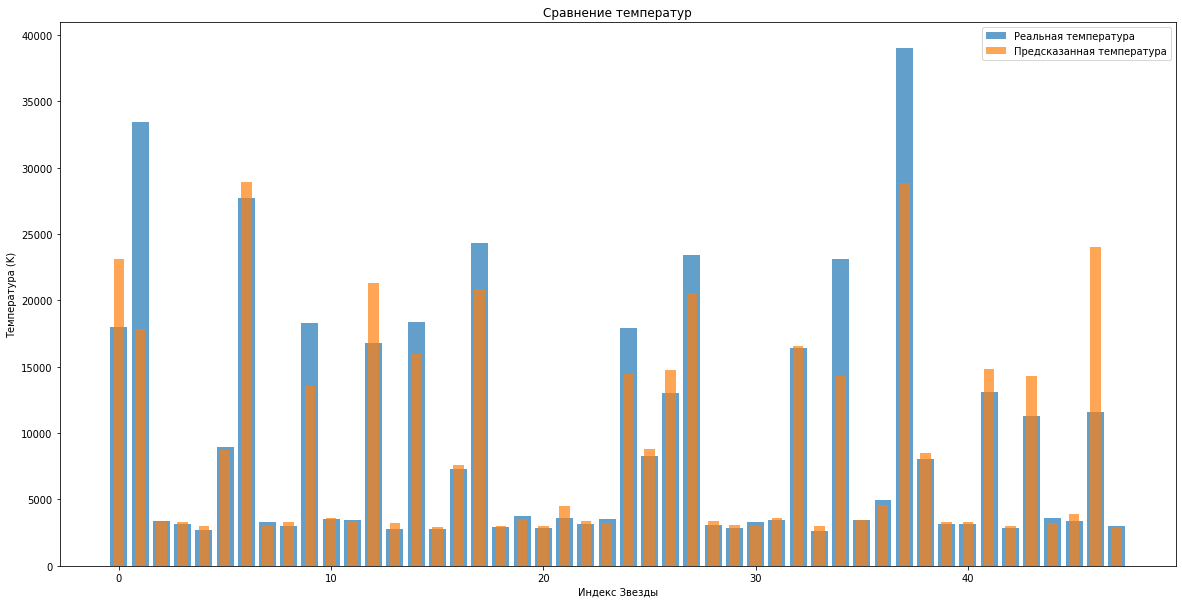

In [88]:
x_indices = np.arange(len(y_valid))
plt.figure(figsize=(20, 10))
plt.bar(x_indices, y_valid, width=0.8, align='center', label='Реальная температура', alpha=0.7)
plt.bar(x_indices, valid_predictions, width=0.5, align='center', label='Предсказанная температура', alpha=0.7)
plt.xlabel('Индекс Звезды')
plt.ylabel('Температура (K)')
plt.title('Сравнение температур')
plt.legend()
plt.show()

Обучили модель, проверили её на валидационных данных и построили график. По графику видим что модель хорошо справляется с предсказаниями температур до 5000 (К), а с очень высокими значениями такими как 30000+ (К) значительно хуже. Большинство значений в валидационной выборке имеют значения меньше 5000 (К).

Построим ещё одну модель в которую добавим dropout и подбор количества слоёв через изменения значения параметра, а не добавкой вручную в классе.

In [89]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size, dropout_prob):
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(hidden_size, output_size))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [90]:
def train_model(model, X_train, y_train, batch_size, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model.forward(batch_X)
            loss = torch.sqrt(criterion(outputs, batch_y.unsqueeze(1)))
            loss.backward()
            optimizer.step()

In [91]:
input_size = X_train.shape[1]
hidden_size = 64
num_hidden_layers = 3
output_size = 1
dropout_prob = 0.6
batch_size = 3
num_epochs = 2000
learning_rate = 0.001

model = NeuralNetwork(input_size, hidden_size, num_hidden_layers, output_size, dropout_prob)
train_model(model, X_train, y_train, batch_size, num_epochs, learning_rate)

with torch.no_grad():
        model.eval()
        valid_predictions = model(X_valid)
    
valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_predictions))
print(f'RMSE on valid data: {valid_rmse:.4f}')

RMSE on valid data: 3130.0830


C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\numpy\lib\stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\numpy\lib\stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m,

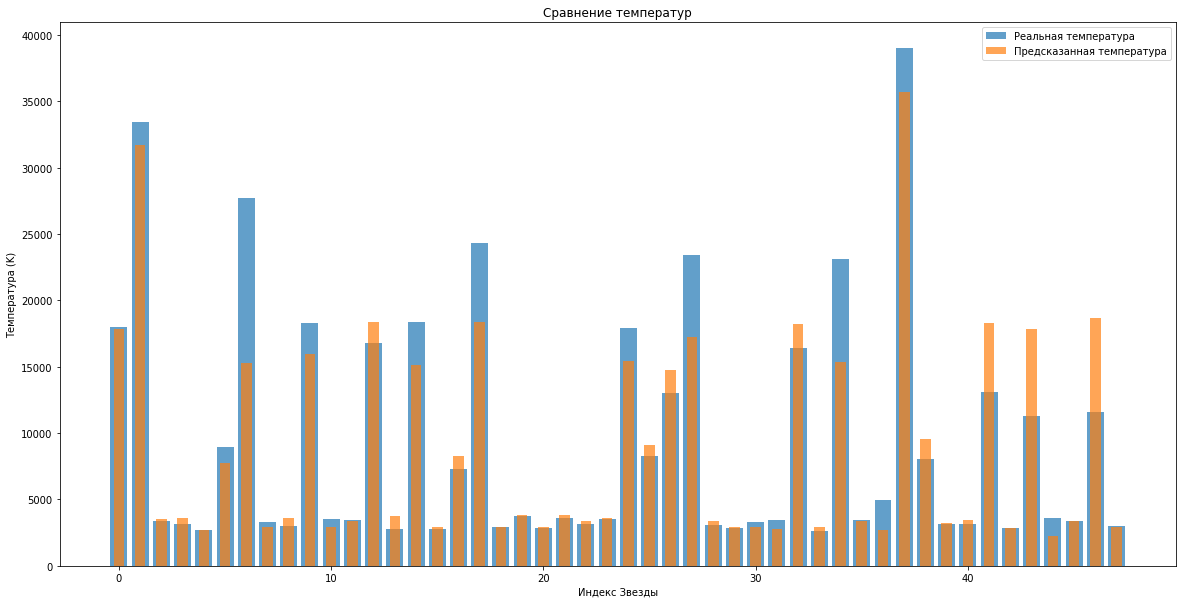

In [92]:
x_indices = np.arange(len(y_valid))
plt.figure(figsize=(20, 10))
plt.bar(x_indices, y_valid, width=0.8, align='center', label='Реальная температура', alpha=0.7)
plt.bar(x_indices, valid_predictions, width=0.5, align='center', label='Предсказанная температура', alpha=0.7)
plt.xlabel('Индекс Звезды')
plt.ylabel('Температура (K)')
plt.title('Сравнение температур')
plt.legend()
plt.show()

Модель построили, обучили и посмотрели как она справляется с валидационными данными. По графику видим что как и первая модель, хорошо получается делать предсказания на значениях меньше 5000 (К). В отличии от первой модели, предсказания очень больших значений улучшились, но немногот ухудшились в диапазоне 20000-30000 (К).

<a id='nn_conclusion'></a>
### Выводы по базовой нейронной сети 

Создали две базовые модели нейронной сети.

- В первой мы слои вручную прописали в класс, а так же функцию активации для каждого слоя. Прописали два скрытых слоя. В качестве функции активации выбрали LeakyReLU на всех слоях. Написали функцию для обучения этой модели. Использовали оптимизатор Adam.  Провели оценку качества обученной модели (на валидационных данных) по RMSE и построили график на котором можно увидеть реальные температуре в сравнении с теми что предсказала модель.
- Вторая модель отличается тем что количество слоёв мы можем менять изменяя переменную вместо того чтобы вручную в классе их прописывать, так же использовали контейнер Sequential. Другое изменении в том что добавили dropout в качестве функции активации используем Linear. В остальном всё так же: оптимизатор Adam, метрика RMSE, оценка модели по валидационной выборке и постороение графика.

Вторая модель показала себя лучше чем первая.

<a id='imp_nn'></a>
## Улучшение нейронной сети

Сделаем перебор гиперпараметров для определения лучшей модели которую в последствии используем на тестовой выборке.

In [93]:
%%time

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    n_in_neurons = X_train.shape[1]
    n_hidden_neurons_1 = [32, 64]
    n_hidden_neurons_2 = [32]
    n_out_neurons = 1
    batch_sizes = [1, 3]
    num_epochs = [500, 1000]
    learning_rate = 0.001


    best_rmse = float("inf")
    best_params = {}
    best_model_1 = None


    for (n_hidden_neurons_1, n_hidden_neurons_2, batch_size, num_epochs) in itertools.product(
        n_hidden_neurons_1, n_hidden_neurons_2, batch_sizes, num_epochs):

        model = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

        fit_model(model, X_train, y_train, num_epochs, batch_size, learning_rate)

        with torch.no_grad():
            model.eval()
            valid_predictions = model(X_valid)

        valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_predictions.cpu().numpy()))

        if valid_rmse < best_rmse:
            best_rmse = valid_rmse
            best_params = {
                "n_hidden_neurons_1": n_hidden_neurons_1,
                "n_hidden_neurons_2": n_hidden_neurons_2,
                "batch_size": batch_size,
                "epochs": num_epochs,
            }
            best_model_1 = model

        
print("Best Parameters:")
print(best_params)
print("Best RMSE on validation data:", best_rmse)

Best Parameters:
{'n_hidden_neurons_1': 32, 'n_hidden_neurons_2': 32, 'batch_size': 1, 'epochs': 1000}
Best RMSE on validation data: 3029.932
CPU times: total: 18min 34s
Wall time: 4min 29s


In [94]:
%%time


input_size = X_train.shape[1]
hidden_sizes = [32, 64]
num_layers = 3
output_size = 1
dropout_values = [0.6, 0.8]
batch_sizes = [3, 5]
num_epochs = [1500, 2000]
learning_rate = 0.001


best_rmse = float("inf")
best_params = {}
best_model_2 = None


for (hidden_size, dropout, batch_size, epochs) in itertools.product(
    hidden_sizes, dropout_values, batch_sizes, num_epochs
):

    model = NeuralNetwork(input_size, hidden_size, num_layers, output_size, dropout)

    train_model(model, X_train, y_train, batch_size, epochs, learning_rate)

    with torch.no_grad():
        model.eval()
        valid_predictions = model(X_valid)

    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_predictions.cpu().numpy()))

    if valid_rmse < best_rmse:
        best_rmse = valid_rmse
        best_params = {
            "hidden_size": hidden_size,
            "dropout": dropout,
            "batch_size": batch_size,
            "epochs": epochs,
        }
        best_model_2 = model


print("Best Parameters:")
print(best_params)
print("Best RMSE on validation data:", best_rmse)

Best Parameters:
{'hidden_size': 64, 'dropout': 0.6, 'batch_size': 3, 'epochs': 1500}
Best RMSE on validation data: 2790.0457
CPU times: total: 2h 15min 5s
Wall time: 11min 16s


Перебрали различные варианты параметров для обоих моделей. Вторая модель показала себя лучше на валидационной выборке, будем использовать её. Посмотрим на RMSE на тестовой выборке.

In [95]:
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        model.eval()
        predictions = model(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions.cpu().numpy()))
    print(f'RMSE on test data: {rmse:.2f}')
    
    
    x_indices = np.arange(len(y_test))
    plt.figure(figsize=(15, 8))
    plt.bar(x_indices, y_test, width=0.8, align='center', label='Реальная температура', alpha=0.7)
    plt.bar(x_indices, predictions, width=0.5, align='center', label='Предсказанная температура', alpha=0.7)
    plt.xlabel('Индекс Звезды')
    plt.ylabel('Температура (K)')
    plt.title('Сравнение температур')
    plt.legend()
    plt.show()


RMSE on test data: 3992.93


C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\numpy\lib\stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\numpy\lib\stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m,

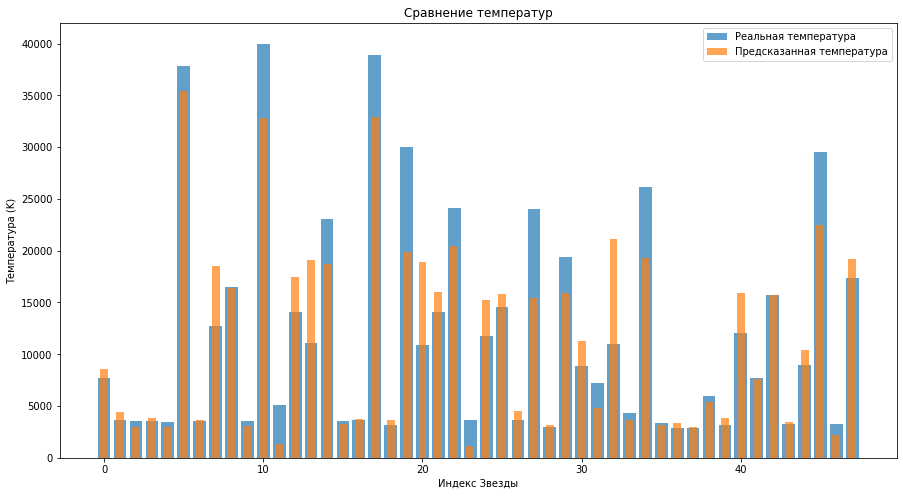

In [96]:
evaluate_model(best_model_2, X_test, y_test)

Получили RMSE примерно 3992.9 на тестовой выборке. На графике видим различия с валидационной выборкой, в тестовой данных более разнообразные. Но общая тенденция сохранилась, в диапазоне 20000-30000 (К) модель не очень удачно делает предсказания, с остальными значениями справляется лучше.

In [98]:
data = [
    ["Первая модель", 3832.8, 3029.9, "-"],
    ["Вторая модель", 3130.1, 2790, 3992.9]
]

headers = ["Модель", "RMSE на Baseline", "RMSE на валидационных данных", "RMSE на тестовых данных"]

df = pd.DataFrame(data, columns=headers)

display(df)

,Модель,RMSE на Baseline,RMSE на валидационных данных,RMSE на тестовых данных
0,Первая модель,3832.8,3029.9,-
1,Вторая модель,3130.1,2790.0,3992.9


<a id='conclusion'></a>
## Выводы

- Первая модель:
 - RMSE на валидационных данных: 3029.9.
 - Решение включает перебор параметров сети с фиксированной архитектурой.
 - В качестве функции активации использована "Leaky ReLU".
 - Количество скрытых слоев: 2.
 - Архитектура сети: 64 нейрона в первом скрытом слое, 32 нейрона во втором скрытом слое и 1 выходной нейрон.


- Вторая модель:
 - RMSE на валидационных данных: 2790.
 - Решение включает перебор параметров сети с вариативной архитектурой и параметрами.
 - В качестве функции активации использованы линейные слои с дропаутом.
 - Количество скрытых слоев: 3.
 - Архитектура сети: 64 нейрона в скрытых слоях, 1 выходной нейрон.
 
 Для обоих моделей использовали оптимизатор Adam. Обе модели показали хорошие результаты в снижении ошибки на валидационных данных. Вторая модель показала более низкий RMSE как на валидационных данных (2790 против 3029.9). Вторая модель также имеет преимущество в архитектурной гибкости благодаря параметризированной архитектуре и использованию дропаута. Это позволяет ей лучше адаптироваться к разнообразным данным и предотвращать переобучение. Также использование линейной функции активации во второй модели для имеющихся данных было лучшим выбором. Получили RMSE на тестовых данных используя вторую модель 3992.9. Можем порекомендовать использовать вторую модель для предсказания температуры звезд.